# Résultats 

#### Données 

In [76]:
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import numpy as np

import os
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import mean_absolute_error, max_error, mean_absolute_percentage_error

import math

from xgboost import XGBRegressor
from sklearn.neural_network import MLPRegressor

from sklearn.preprocessing import PowerTransformer
import h5py
from keras.models import load_model

import matplotlib.pyplot as plt
import seaborn as sns

In [77]:
df = pd.read_excel('./df_cleaned.xlsx')

In [78]:
X = df.iloc[:, :23]  # données particules
Y = df.iloc[:,23:31]  # données optiques
L = df.iloc[:,31:]  # données Lidar

#### Fonctions 

In [79]:
import matplotlib.pyplot as plt
import numpy as np
import os

def plot_prediction(Y_test, predictions, figsize, im_name):
    # Nombre de graphiques à afficher par ligne
    n_cols = 3
    n_rows = (len(Y_test.columns) + n_cols - 1) // n_cols  # Calculer le nombre de lignes nécessaires
    
    # Créer une figure avec n sous-graphiques (grilles de graphiques)
    fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=figsize)
    
    # Aplatir les axes si plus de 1 ligne
    axes = axes.flatten()
    
    # Boucle sur chaque variable cible
    for idx, col in enumerate(Y_test.columns):
        ax = axes[idx]  # Sélectionner le subplot (graphique)
        
        # Tracer les valeurs réelles vs prédictions pour chaque modèle
        for model_name, pred_df in predictions.items():
            ax.scatter(Y_test[col].values, pred_df[col].values, label=f'{model_name}', alpha=0.6, s=30)
    
        # Tracer une ligne de référence y = x pour voir la correspondance entre valeurs réelles et prédictions
        x_range = np.linspace(min(Y_test[col].min(), pred_df[col].min()), max(Y_test[col].max(), pred_df[col].max()), 100)
        ax.plot(x_range, x_range, linestyle="--", color="black", label="y = x")
    
        # Ajouter le titre et les légendes
        ax.set_title(f'Comparison of ground truth and prediction for: {col}', fontsize=10)
        ax.set_xlabel(f'Ground truth {col}', fontsize=8)
        ax.set_ylabel(f'Predictions {col}', fontsize=8)
        ax.legend(fontsize=8)
        ax.grid(True)
    
    # Supprimer les axes inutilisés (si le nombre d'axes est supérieur au nombre de graphiques)
    for idx in range(len(Y_test.columns), len(axes)):
        fig.delaxes(axes[idx])

    # Ajuster l'espace entre les graphiques
    plt.tight_layout()
    
    # Chemin pour sauvegarder l'image
    output_dir = "../Images_finales"  # Nom du dossier
    if not os.path.exists(output_dir):  # Créer le dossier s'il n'existe pas
        os.makedirs(output_dir)
    
    output_path = os.path.join(output_dir, im_name)  # Chemin complet du fichier
    
    # Sauvegarder le plot
    plt.savefig(output_path, dpi=300, bbox_inches='tight')
    
    plt.show()
    
    print(f"Graphique sauvegardé dans : {output_path}")

In [80]:
def plot_residus(Y_test,predictions,figsize) : 
    n_cols = 3
    n_rows = (len(Y_test.columns) + n_cols - 1) // n_cols 
    fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=figsize)

    # Aplatir les axes si plus de 1 ligne
    axes = axes.flatten()
    
    # Boucle sur chaque variable cible
    for idx, col in enumerate(Y_test.columns):
        ax = axes[idx]  # Sélectionner le subplot (graphique)
    
        # Tracer les résidus pour chaque modèle
        for model_name, pred_df in predictions.items():
            residuals = Y_test[col].values - pred_df[col].values  # Calcul des résidus
            ax.scatter(Y_test[col].values, residuals, label=f'{model_name}', alpha=0.6, s=30)
        
        # Ajouter une ligne horizontale y = 0 pour référence
        ax.axhline(0, color='black', linestyle='--', linewidth=2, label='y = 0')
    
        # Ajouter le titre et les légendes
        ax.set_title(f'Residuals graph of: {col}', fontsize=10)
        ax.set_xlabel(f'Valeurs réelles {col}', fontsize=8)
        ax.set_ylabel('Residuals', fontsize=8)
        ax.legend(fontsize=8)
        ax.grid(True)
    
    # Ajuster l'espace entre les graphiques
    plt.tight_layout()
    
    # Afficher les graphiques
    plt.show()

In [81]:
# Fonction pour mettre en évidence la meilleure valeur par ligne
def highlight_best_by_row(data, higher_is_better=False):
    # Initialiser un DataFrame vide pour stocker les styles
    styles = pd.DataFrame('', index=data.index, columns=data.columns)
    
    # Identifier la meilleure colonne pour chaque ligne
    if higher_is_better:
        best_columns = data.idxmax(axis=1)  # Colonne avec la valeur maximale
    else:
        best_columns = data.idxmin(axis=1)  # Colonne avec la valeur minimale
    
    # Appliquer le style uniquement à la meilleure valeur par ligne
    for idx, col in best_columns.items():
        styles.loc[idx, col] = 'background-color: lightgreen'
    
    return styles

## X_L 

In [82]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
pt = PowerTransformer(method='yeo-johnson')

X_test=X.reset_index(drop=True)
Y_test=L.reset_index(drop=True)


X_test_transformed = scaler.fit_transform(X_test)  #pt.fit_transform(X_train)
Y_test_transformed = pd.DataFrame(Y_test, columns=Y_test.columns)

#### Téléchargement des modèls 

In [83]:
from joblib import load  # Pour charger les modèles enregistrés
import os
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score

# Dossier où les modèles ont été enregistrés
output_dir = 'Best_models/X_L_final/'

# Initialisation des DataFrames pour les prédictions
Y_pred_XL_KRR = pd.DataFrame()
Y_pred_XL_GB = pd.DataFrame()
Y_pred_XL_XGB = pd.DataFrame()
Y_pred_XL_ANN = pd.DataFrame()

# Liste des modèles à charger
model_names = ['KRR', 'GB', 'XGB', 'ANN']  # Ajoutez ici les modèles que vous avez enregistrés

# Initialisation des dictionnaires pour stocker les erreurs
errors_KRR = {}
errors_GB = {}
errors_XGB = {}
errors_ANN = {}

# Charger et prédire avec chaque modèle enregistré
for model_name in model_names:
    model_path = os.path.join(output_dir, model_name)
    
    model_files = [f for f in os.listdir(model_path) if f.endswith('.joblib')]
    
    # Initialisation des dictionnaires pour les prédictions
    y_pred = {}
    var = []
    
    for model_file in model_files:
        # Extraire le nom de la variable cible à partir du nom du fichier
        variable_name = model_file.split(f'_best_model_{model_name}')[0]
        var.append(variable_name)
        
        # Charger le modèle
        model = load(os.path.join(model_path, model_file))

        # Effectuer les prédictions pour chaque variable
        y_pred[variable_name] = model.predict(X_test_transformed)  # Prédictions pour chaque variable
        
        # Calculer les erreurs
        mse = mean_squared_error(Y_test[variable_name], y_pred[variable_name])
        mape = mean_absolute_percentage_error(Y_test[variable_name], y_pred[variable_name])
        r2 = r2_score(Y_test[variable_name], y_pred[variable_name])
        
        # Stocker les erreurs
        if model_name == 'KRR':
            errors_KRR[variable_name] = {'MSE': mse, 'MAPE': mape, 'R2': r2}
        elif model_name == 'GB':
            errors_GB[variable_name] = {'MSE': mse, 'MAPE': mape, 'R2': r2}
        elif model_name == 'XGB':
            errors_XGB[variable_name] = {'MSE': mse, 'MAPE': mape, 'R2': r2}
        elif model_name == 'ANN':
            errors_ANN[variable_name] = {'MSE': mse, 'MAPE': mape, 'R2': r2}
    
    # Convertir les prédictions en DataFrame
    y_pred_df = pd.DataFrame(y_pred, columns=var)
        
    # Ajouter les prédictions au DataFrame correspondant au modèle
    if model_name == 'KRR':
        Y_pred_XL_KRR = y_pred_df  # Assigner les prédictions au bon DataFrame
    elif model_name == 'GB':
        Y_pred_XL_GB = y_pred_df
    elif model_name == 'XGB':
        Y_pred_XL_XGB = y_pred_df
    elif model_name == 'ANN':
        Y_pred_XL_ANN = y_pred_df

df_errors_XL_KRR = pd.DataFrame(errors_KRR).T[['MSE', 'MAPE', 'R2']]
df_errors_XL_GB = pd.DataFrame(errors_GB).T[['MSE', 'MAPE', 'R2']]
df_errors_XL_XGB = pd.DataFrame(errors_XGB).T[['MSE', 'MAPE', 'R2']]
df_errors_XL_ANN = pd.DataFrame(errors_ANN).T[['MSE', 'MAPE', 'R2']]


### Graphe de prédictions 

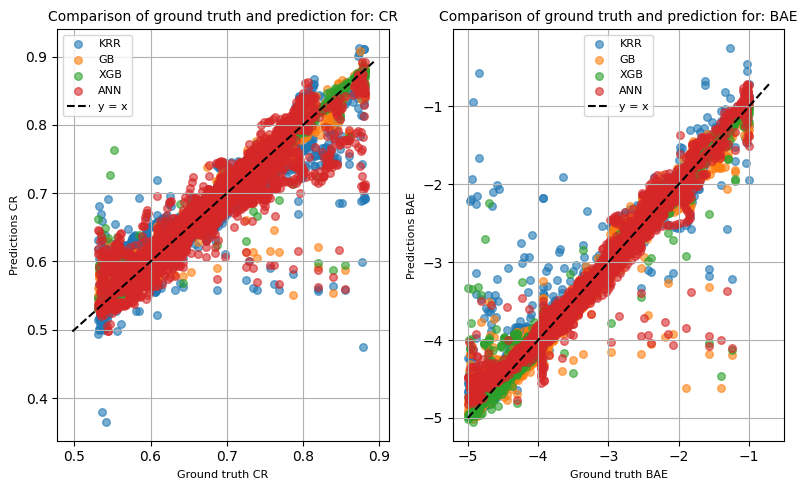

Graphique sauvegardé dans : ../Images_finales\X_L_results.png


In [84]:
import numpy as np
import matplotlib.pyplot as plt

# Dictionnaire contenant les prédictions de chaque modèle
# Vous allez ajouter les prédictions depuis prediction_X_L ici
predictions_XL = {
    'KRR': Y_pred_XL_KRR,  # Remplacer par les prédictions issues de prediction_X_L
    'GB': Y_pred_XL_GB,
    'XGB': Y_pred_XL_XGB,
    'ANN': Y_pred_XL_ANN  # Si vous avez d'autres modèles, vous pouvez les ajouter ici
}

plot_prediction(Y_test,predictions_XL,figsize =((12,5)),im_name = 'X_L_results.png')

#### Observations principales par variable :

CR_660_530 : 

Les points montrent une forte dispersion, surtout pour les valeurs réelles élevées.
Les modèles XGB et ANN semblent légèrement mieux suivre la diagonale y=x, mais les prédictions restent globalement imprécises.
GB et KRR montrent davantage de sous-estimations pour les valeurs élevées.

CR_530_467 :

Les prédictions sont encore plus éloignées de la diagonale.
Les modèles GB, XGB et ANN montrent de meilleures approximations pour les petites valeurs, mais une forte sous-estimation pour les valeurs supérieures à 10 000.
KRR semble particulièrement inadapté, avec des prédictions systématiquement faibles.

CR_467_660 :

Une dispersion importante est visible pour toutes les valeurs réelles.
Les modèles GB et ANN semblent légèrement mieux suivre la tendance pour les petites valeurs, mais la qualité des prédictions est globalement faible.

BAE_660_530 :

Les modèles ANN et XGB s'approchent de la diagonale y=x pour une large plage de valeurs, avec des points bien alignés.
GB et KRR montrent une dispersion plus importante, surtout pour les valeurs extrêmes.
Les prédictions ANN sont les plus proches de la réalité, notamment pour les valeurs centrales.

BAE_530_467 :

Les points sont globalement alignés, mais une légère dispersion reste visible pour les valeurs extrêmes.
XGB et ANN continuent de mieux s'approcher de la diagonale, tandis que GB et KRR montrent des biais.

BAE_467_660 :

La plupart des prédictions sont proches de la diagonale, en particulier pour ANN et XGB.
GB et KRR présentent des erreurs plus importantes, avec des sous-estimations pour les valeurs les plus élevées.

#### Analyse globale :

Performance par modèle :

ANN et XGB sont les modèles les plus robustes globalement, particulièrement pour les variables BAE, où leurs prédictions s'alignent mieux sur les valeurs réelles.
GB montre des performances moyennes, mais est souvent en dessous de la réalité pour des valeurs élevées.
KRR est systématiquement le moins performant, avec des prédictions plus dispersées et des biais évidents.

Différence entre les variables :

Les variables BAE sont mieux prédites que CR. Les valeurs de CR montrent une très forte dispersion, ce qui peut indiquer des caractéristiques plus complexes.

#### Conclusion :

ANN et XGB sont les modèles les plus fiables pour ces ensembles, surtout pour la variable BAE.
Les variables CR nécessitent une réévaluation : des modèles plus complexes pourraient être nécessaires.
KRR est inadapté pour ces données.

### Graphe des résidus 

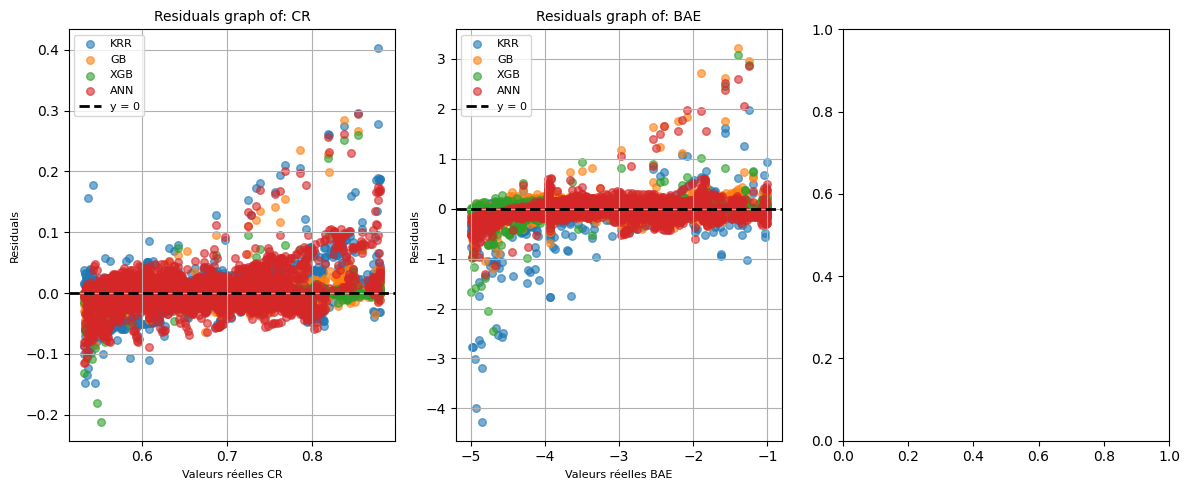

In [85]:
plot_residus(Y_test,predictions_XL,figsize =((12,5)))

#### Observations principales par variable :

CR_660_530 :

Les points montrent une forte dispersion des résidus, en particulier pour les valeurs réelles élevées.
Les modèles XGB et ANN semblent fournir des résidus moins dispersés pour les petites valeurs, mais les prédictions restent globalement imprécises.
Les modèles GB et KRR montrent des sous-estimations marquées pour les valeurs réelles élevées, indiquant une moindre performance.

CR_530_467 :

La dispersion des résidus est encore plus prononcée, surtout pour les valeurs réelles supérieures à 10 000.
Les modèles GB, XGB, et ANN offrent des approximations relativement bonnes pour les petites valeurs, mais sous-estiment fortement les grandes valeurs.
KRR est particulièrement inadapté, avec des résidus systématiquement très importants, soulignant une incapacité à capturer les tendances des données.

CR_467_660 :

Une forte dispersion des résidus est visible pour toutes les plages de valeurs réelles.
Les modèles GB et ANN semblent légèrement mieux suivre la tendance pour les petites valeurs réelles, mais les prédictions globales restent imprécises.
KRR et XGB montrent des résidus considérables pour des valeurs élevées, révélant des limites dans ces cas.

BAE_660_530 :

Les modèles ANN et XGB produisent des résidus beaucoup plus faibles, indiquant des prédictions proches des valeurs réelles.
Les modèles GB et KRR montrent une dispersion notable, avec des erreurs plus importantes pour les valeurs extrêmes.
ANN est le modèle le plus précis, particulièrement pour les valeurs centrales.

BAE_530_467 :

Les résidus sont globalement concentrés autour de y=0, bien que les valeurs extrêmes montrent une légère dispersion.
Les modèles XGB et ANN continuent de fournir les meilleures performances, avec des prédictions alignées sur les valeurs réelles.
GB et KRR montrent des biais notables, avec des prédictions moins précises pour les extrêmes.

BAE_467_660 :

La plupart des résidus sont faibles, en particulier pour ANN et XGB, qui restent proches de y=0.
GB et KRR montrent des erreurs plus importantes, particulièrement pour les valeurs réelles élevées, où des sous-estimations sont visibles.

#### Analyse globale :

Performance par modèle :

ANN et XGB sont les modèles les plus robustes, offrant des prédictions cohérentes, particulièrement pour les variables BAE.
GB montre des performances acceptables, mais est souvent moins précis pour les valeurs élevées.
KRR est le modèle le moins performant, avec des résidus systématiquement élevés et une incapacité à capturer la structure des données.

Différences entre les variables :

Les variables BAE sont nettement mieux prédites que CR.
Les variables CR présentent une forte dispersion des résidus, indiquant une forte complexité des données ou des caractéristiques mal représentées dans les modèles.

#### Conclusion :
ANN et XGB se distinguent comme les modèles les plus fiables pour ces ensembles de données, particulièrement pour les variables BAE.
Les variables CR nécessitent une révision approfondie.
KRR est clairement inadapté pour ces données et pourrait être exclu de l'analyse.

### Tableaux des erreurs 

In [12]:
# Remplir les dictionnaires pour MSE, MAPE et R² pour chaque modèle
results_mse = {}
results_mape = {}
results_r2 = {}

results_mse['KRR'] = df_errors_XL_KRR['MSE']
results_mape['KRR'] = df_errors_XL_KRR['MAPE']
results_r2['KRR'] = df_errors_XL_KRR['R2']

results_mse['GB'] = df_errors_XL_GB['MSE']
results_mape['GB'] = df_errors_XL_GB['MAPE']
results_r2['GB'] = df_errors_XL_GB['R2']

results_mse['XGB'] = df_errors_XL_XGB['MSE']
results_mape['XGB'] = df_errors_XL_XGB['MAPE']
results_r2['XGB'] = df_errors_XL_XGB['R2']

results_mse['ANN'] = df_errors_XL_ANN['MSE']
results_mape['ANN'] = df_errors_XL_ANN['MAPE']
results_r2['ANN'] = df_errors_XL_ANN['R2']

# Créer les DataFrames pour chaque métrique
df_mse = pd.DataFrame(results_mse)
df_mape = pd.DataFrame(results_mape)
df_r2 = pd.DataFrame(results_r2)


# Appliquer le style avec la fonction mise à jour
styled_mse = df_mse.style.apply(highlight_best_by_row, higher_is_better=False, axis=None).set_caption("MSE : Meilleure méthode pour chaque paramètre")
styled_mape = df_mape.style.apply(highlight_best_by_row, higher_is_better=False, axis=None).set_caption("MAPE : Meilleure méthode pour chaque paramètre")
styled_r2 = df_r2.style.apply(highlight_best_by_row, higher_is_better=True, axis=None).set_caption("R² : Meilleure méthode pour chaque paramètre")

# Afficher les tableaux
from IPython.display import display
display(styled_mse)
display(styled_mape)
display(styled_r2)

,KRR,GB,XGB,ANN
BAE,0.067529,0.032589,0.022866,0.039614
CR,0.000821,0.000233,0.000153,0.000874


,KRR,GB,XGB,ANN
BAE,0.035418,0.034608,0.017853,0.041816
CR,0.023807,0.011380,0.006703,0.027114


,KRR,GB,XGB,ANN
BAE,0.910218,0.956672,0.969599,0.947332
CR,0.852232,0.957992,0.972458,0.842747


## X_Y 

In [61]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

X_test=X.reset_index(drop=True)
Y_test=Y.reset_index(drop=True)

X_test_transformed =  scaler.fit_transform(X_test)   #pt.transform(X_test)
Y_test_transformed = pd.DataFrame(Y_test, columns=Y_test.columns)

#### Téléchargement des modèls 

In [62]:
from joblib import load  # Pour charger les modèles enregistrés
import os
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score

# Dossier où les modèles ont été enregistrés
output_dir = 'Best_models/X_Y_final/'

# Initialisation des DataFrames pour les prédictions
Y_pred_XY_KRR = pd.DataFrame()
Y_pred_XY_GB = pd.DataFrame()
Y_pred_XY_XGB = pd.DataFrame()
Y_pred_XY_ANN = pd.DataFrame()

# Liste des modèles à charger
model_names = ['KRR', 'GB', 'XGB', 'ANN']  # Ajoutez ici les modèles que vous avez enregistrés

# Initialisation des dictionnaires pour stocker les erreurs
errors_KRR = {}
errors_GB = {}
errors_XGB = {}
errors_ANN = {}

# Charger et prédire avec chaque modèle enregistré
for model_name in model_names:
    model_path = os.path.join(output_dir, model_name)
    
    model_files = [f for f in os.listdir(model_path) if f.endswith('.joblib')]
    
    # Initialisation des dictionnaires pour les prédictions
    y_pred = {}
    var = []
    
    for model_file in model_files:
        # Extraire le nom de la variable cible à partir du nom du fichier
        variable_name = model_file.split(f'_best_model_{model_name}')[0]
        var.append(variable_name)
        
        # Charger le modèle
        model = load(os.path.join(model_path, model_file))
    
        # Effectuer les prédictions pour chaque variable
        y_pred[variable_name] = model.predict(X_test_transformed)  # Prédictions pour chaque variable
        
        # Calculer les erreurs
        mse = mean_squared_error(Y_test[variable_name], y_pred[variable_name])
        mape = mean_absolute_percentage_error(Y_test[variable_name], y_pred[variable_name])
        r2 = r2_score(Y_test[variable_name], y_pred[variable_name])
        
        # Stocker les erreurs
        if model_name == 'KRR':
            errors_KRR[variable_name] = {'MSE': mse, 'MAPE': mape, 'R2': r2}
        elif model_name == 'GB':
            errors_GB[variable_name] = {'MSE': mse, 'MAPE': mape, 'R2': r2}
        elif model_name == 'XGB':
            errors_XGB[variable_name] = {'MSE': mse, 'MAPE': mape, 'R2': r2}
        elif model_name == 'ANN':
            errors_ANN[variable_name] = {'MSE': mse, 'MAPE': mape, 'R2': r2}
    
    # Convertir les prédictions en DataFrame
    y_pred_df = pd.DataFrame(y_pred, columns=var)
        
    # Ajouter les prédictions au DataFrame correspondant au modèle
    if model_name == 'KRR':
        Y_pred_XY_KRR = y_pred_df  # Assigner les prédictions au bon DataFrame
    elif model_name == 'GB':
        Y_pred_XY_GB = y_pred_df
    elif model_name == 'XGB':
        Y_pred_XY_XGB = y_pred_df
    elif model_name == 'ANN':
        Y_pred_XY_ANN = y_pred_df

df_errors_XY_KRR = pd.DataFrame(errors_KRR).T[['MSE', 'MAPE', 'R2']]
df_errors_XY_GB = pd.DataFrame(errors_GB).T[['MSE', 'MAPE', 'R2']]
df_errors_XY_XGB = pd.DataFrame(errors_XGB).T[['MSE', 'MAPE', 'R2']]
df_errors_XY_ANN = pd.DataFrame(errors_ANN).T[['MSE', 'MAPE', 'R2']]


#### Graphe de prédiction 

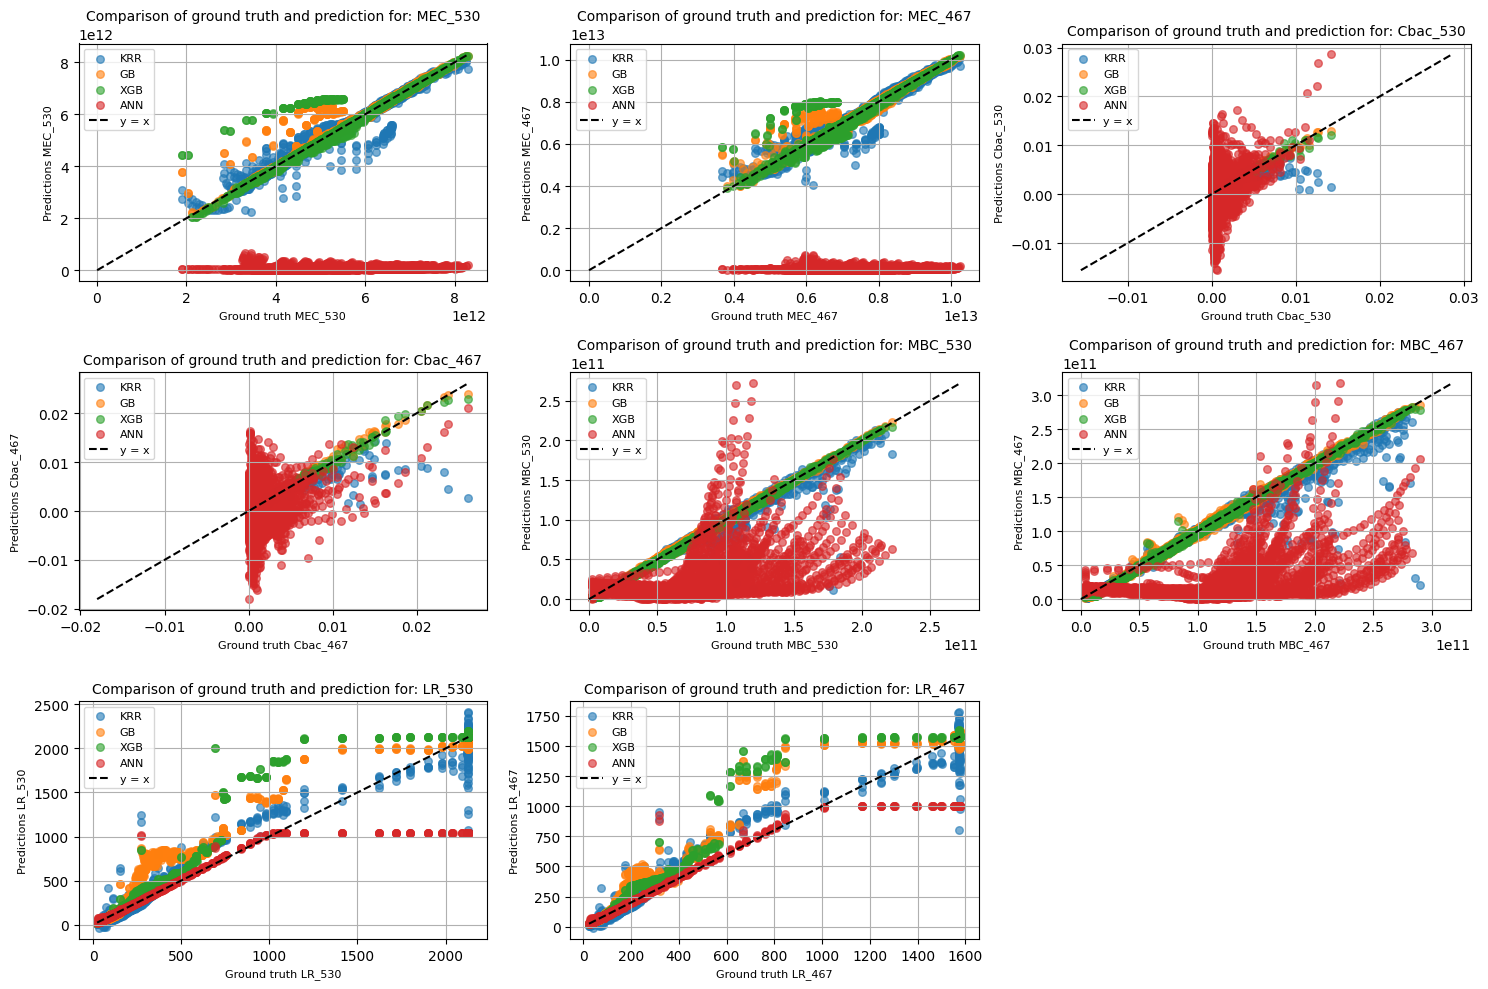

Graphique sauvegardé dans : ../Images_finales\X_Y_results.png


In [63]:
import numpy as np
import matplotlib.pyplot as plt

# Dictionnaire contenant les prédictions de chaque modèle
# Vous allez ajouter les prédictions depuis prediction_X_L ici
predictions_XY = {
    'KRR': Y_pred_XY_KRR,  # Remplacer par les prédictions issues de prediction_X_L
    'GB': Y_pred_XY_GB,
    'XGB': Y_pred_XY_XGB,
    'ANN': Y_pred_XY_ANN  # Si vous avez d'autres modèles, vous pouvez les ajouter ici
}


plot_prediction(Y_test,predictions_XY,figsize =((15,10)),im_name = 'X_Y_results.png')

On observe ici que pour la prédiction de MBC, MEC et LR, ANN semble être la meilleure méthode. En revanche, pour C_bac elle est la moins bonne. 

#### Alignement avec la diagonale (y = x) :
- Les points proches de la diagonale montrent une meilleure précision des modèles.
- Les prédictions des modèles sont généralement bien alignées pour certaines variables (comme MBC, MEC et LR), mais moins pour Cbac.

#### Comparaison des modèles :
- Les modèles Gradient Boosting (GB), XGBoost (XGB) et Réseaux de neurones (ANN) semblent mieux suivre la diagonale par rapport à KRR, en particulier pour les ensembles MBC et LR.
- Pour des variables comme Cbac, les prédictions des modèles semblent très concentrées autour d'une valeur constante, ce qui indique probablement un mauvais ajustement.

#### Dispersion des points :
Pour certaines variables (comme MEC et LR), il y a une plus grande dispersion autour de la diagonale, ce qui suggère que les modèles ont parfois des erreurs significatives.

#### Comportement selon la plage :
Les résultats varient entre les plages 660, 530 et 467. 
Par exemple :
- 660 semble souvent avoir une meilleure précision globale (points plus proches de la diagonale).
- 467 montre des erreurs plus importantes, avec des prédictions parfois éloignées.

#### Conclusion :
- Meilleures performances globales : Les modèles GB, XGB et ANN semblent plus fiables pour les ensembles comme MBC, MEC et LR.
- Performances variables : Pour Cbac, les modèles sont inadéquats (prédictions trop constantes).

### Graphe des résidus 

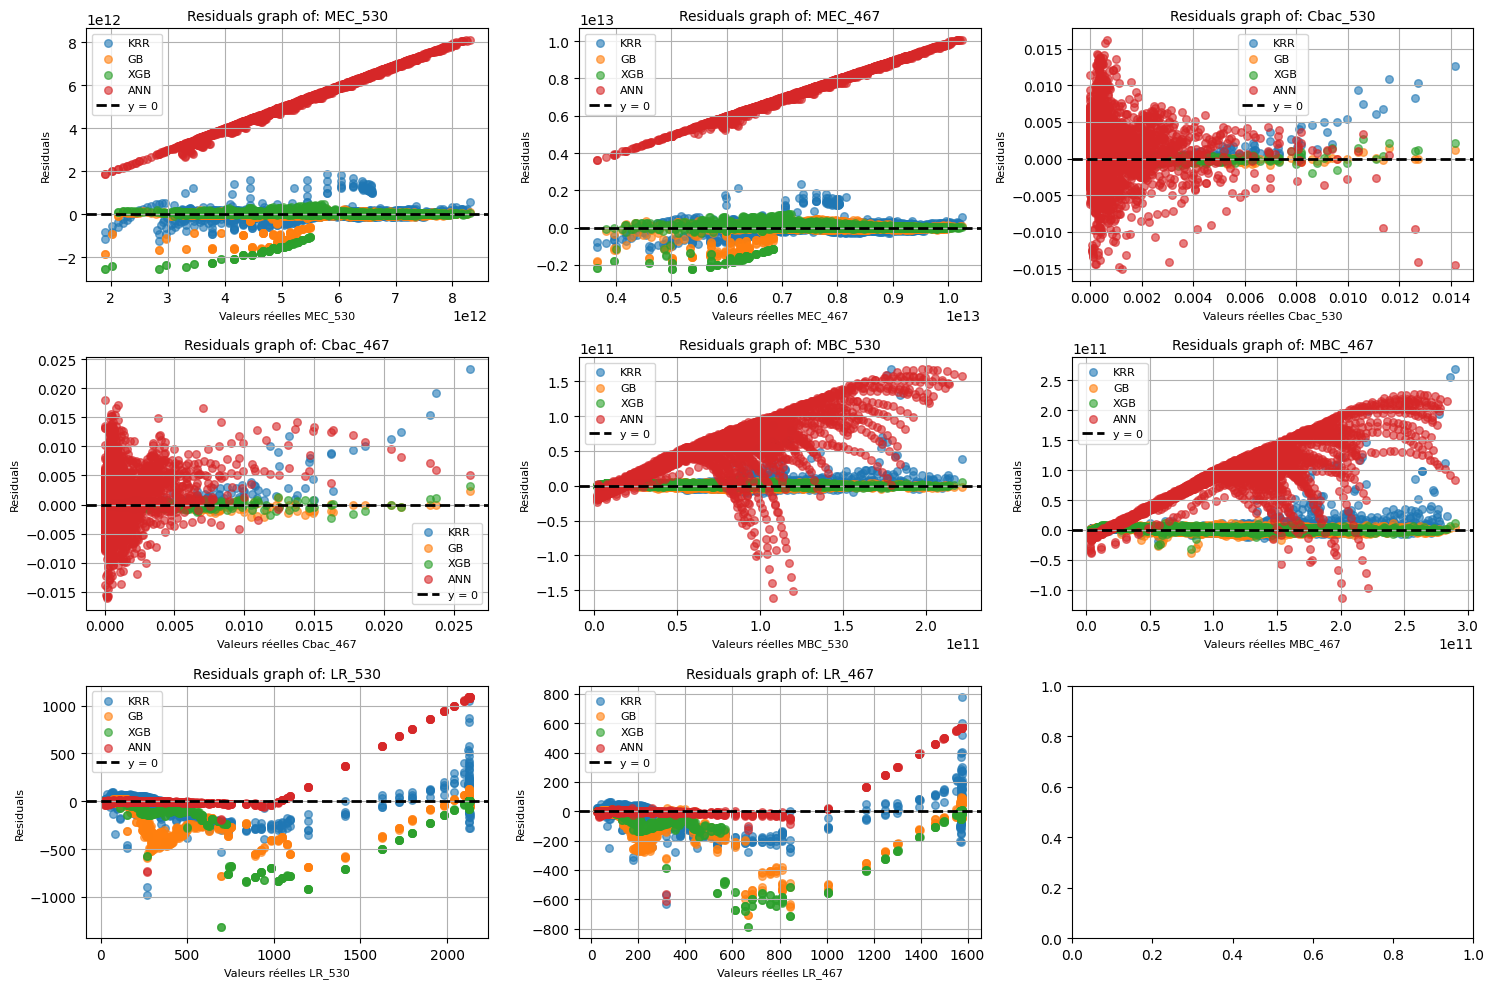

In [18]:
plot_residus(Y_test,predictions_XY,figsize =((15,10)))

#### Observations principales par variable :

MBC :

Les résidus sont bien centrés autour de 0 pour GB, XGB, et ANN, surtout sur 660.
KRR montre une dispersion plus importante des résidus, surtout pour les valeurs plus élevées.
Pour 467, les résidus deviennent plus hétérogènes, avec des erreurs systématiques dans certaines plages de valeurs réelles.

MEC :

Les modèles GB, XGB et ANN affichent des résidus mieux contrôlés que KRR.
KRR montre des erreurs systématiques pour certaines plages de valeurs réelles.

Cbac :

Les modèles ont de très faibles résidus proches de zéro. Cela correspond probablement à des prédictions constantes (comme vu dans le graphique précédent).
Cette performance pourrait indiquer que la variable est mal représentée par les modèles, ou que les valeurs réelles sont très petites et peu variables.

LR :

Les résidus restent globalement centrés autour de 0, mais on observe une plus grande dispersion pour les valeurs extrêmes, surtout avec 467.
ANN et XGB semblent mieux contrôler les erreurs dans certaines plages, tandis que KRR présente des résidus plus importants.

#### Interprétation globale :

Meilleurs modèles : 

GB, XGB, et ANN semblent être plus robustes dans la plupart des cas, avec des résidus mieux centrés et moins de biais systématique.

Problèmes identifiables :

Les modèles semblent avoir plus de difficultés sur les plages 467 (augmentation des résidus et dispersion).
Les résidus pour certaines variables (notamment Cbac) sont négligeables, ce qui pourrait indiquer un problème dans les données ou dans la représentation de la variable.

#### Conclusion :

Les graphiques des résidus confirment les observations précédentes : GB, XGB, et ANN sont globalement plus performants. Toutefois, des ajustements pourraient être nécessaires pour les variables comme Cbac et certaines plages de données.

#### Tableaux des erreurs 

In [19]:
results_mse['KRR'] = df_errors_XY_KRR['MSE']
results_mape['KRR'] = df_errors_XY_KRR['MAPE']
results_r2['KRR'] = df_errors_XY_KRR['R2']

results_mse['GB'] = df_errors_XY_GB['MSE']
results_mape['GB'] = df_errors_XY_GB['MAPE']
results_r2['GB'] = df_errors_XY_GB['R2']

results_mse['XGB'] = df_errors_XY_XGB['MSE']
results_mape['XGB'] = df_errors_XY_XGB['MAPE']
results_r2['XGB'] = df_errors_XY_XGB['R2']

results_mse['ANN'] = df_errors_XY_ANN['MSE']
results_mape['ANN'] = df_errors_XY_ANN['MAPE']
results_r2['ANN'] = df_errors_XY_ANN['R2']

# Créer les DataFrames pour chaque métrique
df_mse = pd.DataFrame(results_mse)
df_mape = pd.DataFrame(results_mape)
df_r2 = pd.DataFrame(results_r2)


# Appliquer le style avec la fonction mise à jour
styled_mse = df_mse.style.apply(highlight_best_by_row, higher_is_better=False, axis=None).set_caption("MSE : Meilleure méthode pour chaque paramètre")
styled_mape = df_mape.style.apply(highlight_best_by_row, higher_is_better=False, axis=None).set_caption("MAPE : Meilleure méthode pour chaque paramètre")
styled_r2 = df_r2.style.apply(highlight_best_by_row, higher_is_better=True, axis=None).set_caption("R² : Meilleure méthode pour chaque paramètre")

# Afficher les tableaux
from IPython.display import display
display(styled_mse)
display(styled_mape)
display(styled_r2)

,KRR,GB,XGB,ANN
Cbac_467,0.000001,0.000000,0.000000,0.000018
Cbac_530,0.000000,0.000000,0.000000,0.000014
LR_467,2811.155909,8122.652008,8642.874448,8388.227446
LR_530,5591.229416,17339.616578,15295.993573,30966.566227
MBC_467,168096556313106972672.000000,12851762533094342656.000000,8964157125376222208.000000,9468015467574960586752.000000
MBC_530,62114647435304919040.000000,4323185420277755904.000000,4774595179563032576.000000,3858249438772216201216.000000
MEC_467,64771721470439751417856.000000,55513118779135047499776.000000,103845901789984590921728.000000,58163880761058151916109824.000000
MEC_530,44545146470800631529472.000000,47256042784565225324544.000000,98854621851529001304064.000000,32130637652873075136397312.000000


,KRR,GB,XGB,ANN
Cbac_467,0.119314,2.987281,14.479706,1380.071028
Cbac_530,0.115198,1.725663,24.806433,2326.758761
LR_467,0.100442,0.135276,0.083167,0.057719
LR_530,0.117498,0.158467,0.074957,0.052381
MBC_467,0.046576,0.055128,0.052031,0.823669
MBC_530,0.047431,0.053694,0.059019,0.842995
MEC_467,0.019831,0.016364,0.018016,0.986240
MEC_530,0.020557,0.015593,0.020131,0.981456


,KRR,GB,XGB,ANN
Cbac_467,0.831219,0.994446,0.992164,-3.205804
Cbac_530,0.852993,0.996393,0.986626,-6.707232
LR_467,0.960752,0.886595,0.879332,0.882887
LR_530,0.957433,0.867990,0.883549,0.764245
MBC_467,0.954720,0.996538,0.997585,-1.550382
MBC_530,0.966668,0.997680,0.997438,-1.070414
MEC_467,0.946980,0.954559,0.914996,-46.610772
MEC_530,0.965192,0.963074,0.922754,-24.107277


## L_X

In [64]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

X = df.iloc[:, 2:23]  # données particules
Y = df.iloc[:,23:31]  # données optiques
L = df.iloc[:, [0, 1] + list(range(31, df.shape[1]))]

X = X.rename(columns={'density_bc (g/cm^3)':'density_bc (g cm^3)'})
X = X.rename(columns={'density_organics (g/cm^3)':'density_organics (g cm^3)'})
X = X.rename(columns={'mr_total/bc':'mr_total bc'})
X = X.rename(columns={'mr_nonBC/BC':'mr_nonBC BC'})

# Sélection des variables intéressantes 
variables = ['primary_particle_size (nm)', 
             'vol_equi_radius_outer (nm)', 
             'vol_equi_radius_inner (nm)', 
             'equi_mobility_dia (nm)',
                "mass_bc (g)"]

X = X[variables]

X_test=L.reset_index(drop=True)
Y_test=X.reset_index(drop=True)

X_test_transformed =  scaler.fit_transform(X_test)   #pt.transform(X_test)
Y_test_transformed = pd.DataFrame(Y_test, columns=Y_test.columns)

#### Téléchargement des modèls 

In [65]:
from joblib import load  # Pour charger les modèles enregistrés
import os
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score

# Dossier où les modèles ont été enregistrés
output_dir = 'Best_models/L_X_final/'

# Initialisation des DataFrames pour les prédictions
Y_pred_LX_KRR = pd.DataFrame()
Y_pred_LX_GB = pd.DataFrame()
Y_pred_LX_XGB = pd.DataFrame()
Y_pred_LX_ANN = pd.DataFrame()


# Liste des modèles à charger
model_names = ['KRR', 'GB', 'XGB', 'ANN']  # Ajoutez ici les modèles que vous avez enregistrés

# Initialisation des dictionnaires pour stocker les erreurs
errors_KRR = {}
errors_GB = {}
errors_XGB = {}
errors_ANN = {}

# Charger et prédire avec chaque modèle enregistré
for model_name in model_names:
    model_path = os.path.join(output_dir, model_name)
    
    model_files = [f for f in os.listdir(model_path) if f.endswith('.joblib')]
    
    # Initialisation des dictionnaires pour les prédictions
    y_pred = {}
    var = []
    
    for model_file in model_files:
        # Extraire le nom de la variable cible à partir du nom du fichier
        variable_name = model_file.split(f'_best_model_{model_name}')[0]
        var.append(variable_name)
        
        # Charger le modèle
        model = load(os.path.join(model_path, model_file))
    
        # Effectuer les prédictions pour chaque variable
        y_pred[variable_name] = model.predict(X_test_transformed)  # Prédictions pour chaque variable
        
        # Calculer les erreurs
        mse = mean_squared_error(Y_test[variable_name], y_pred[variable_name])
        mape = mean_absolute_percentage_error(Y_test[variable_name], y_pred[variable_name])
        r2 = r2_score(Y_test[variable_name], y_pred[variable_name])
        
        # Stocker les erreurs
        if model_name == 'KRR':
            errors_KRR[variable_name] = {'MSE': mse, 'MAPE': mape, 'R2': r2}
        elif model_name == 'GB':
            errors_GB[variable_name] = {'MSE': mse, 'MAPE': mape, 'R2': r2}
        elif model_name == 'XGB':
            errors_XGB[variable_name] = {'MSE': mse, 'MAPE': mape, 'R2': r2}
        elif model_name == 'ANN':
            errors_ANN[variable_name] = {'MSE': mse, 'MAPE': mape, 'R2': r2}
    
    # Convertir les prédictions en DataFrame
    y_pred_df = pd.DataFrame(y_pred, columns=var)
        
    # Ajouter les prédictions au DataFrame correspondant au modèle
    if model_name == 'KRR':
        Y_pred_LX_KRR = y_pred_df  # Assigner les prédictions au bon DataFrame
    elif model_name == 'GB':
        Y_pred_LX_GB = y_pred_df
    elif model_name == 'XGB':
        Y_pred_LX_XGB = y_pred_df
    elif model_name == 'ANN':
        Y_pred_LX_ANN = y_pred_df

df_errors_LX_KRR = pd.DataFrame(errors_KRR).T[['MSE', 'MAPE', 'R2']]
df_errors_LX_GB = pd.DataFrame(errors_GB).T[['MSE', 'MAPE', 'R2']]
df_errors_LX_XGB = pd.DataFrame(errors_XGB).T[['MSE', 'MAPE', 'R2']]
df_errors_LX_ANN = pd.DataFrame(errors_ANN).T[['MSE', 'MAPE', 'R2']]


#### Graphe de prédiction 

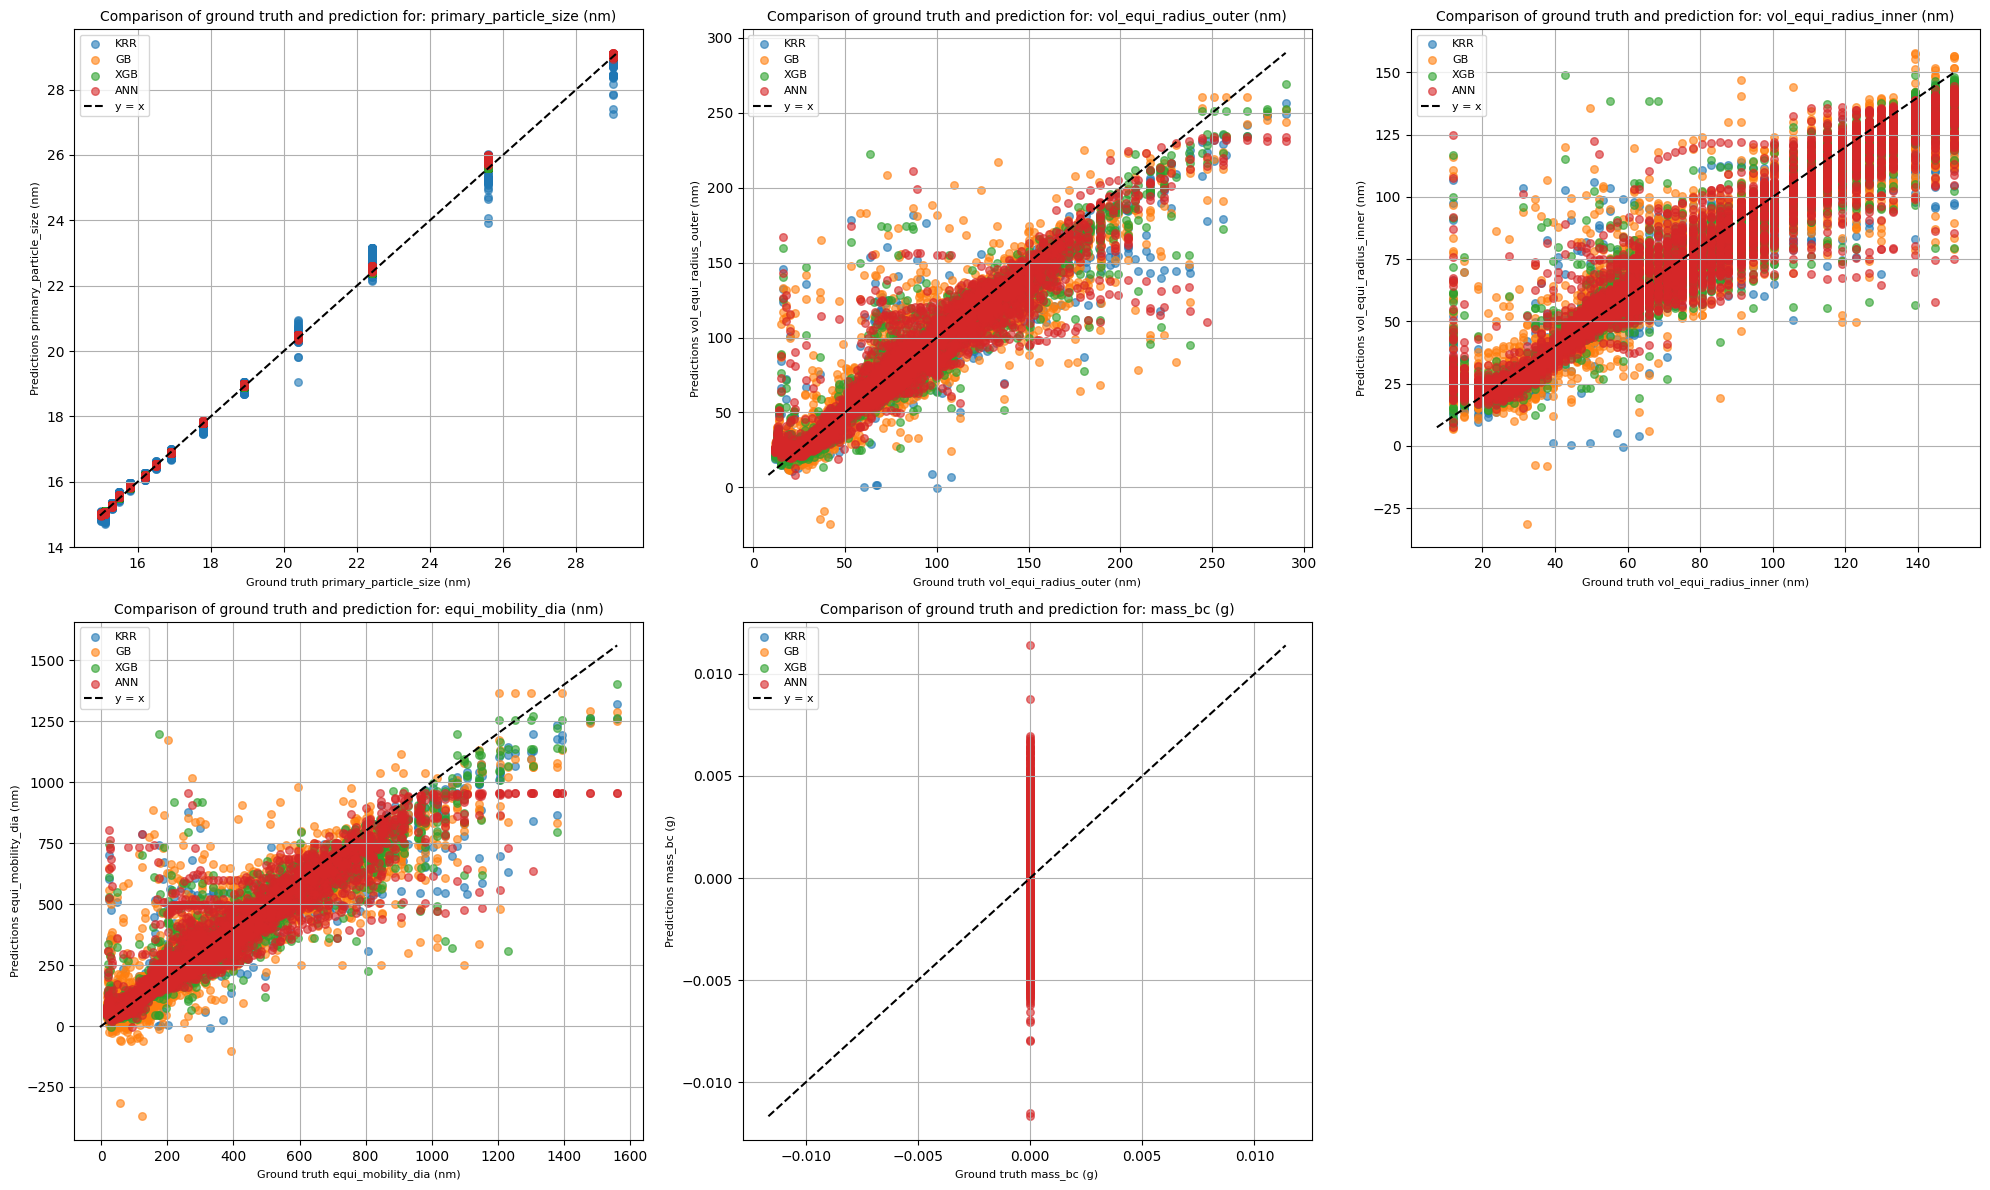

Graphique sauvegardé dans : ../Images_finales\L_X_results.png


In [68]:
predictions_LX = {
    'KRR': Y_pred_LX_KRR,  # Remplacer par les prédictions issues de prediction_X_L
    'GB': Y_pred_LX_GB,
    'XGB': Y_pred_LX_XGB,
    'ANN': Y_pred_LX_ANN  # Si vous avez d'autres modèles, vous pouvez les ajouter ici
}

plot_prediction(Y_test,predictions_LX,figsize =((20,12)),im_name = 'L_X_results.png')

#### Graphe des résidus 

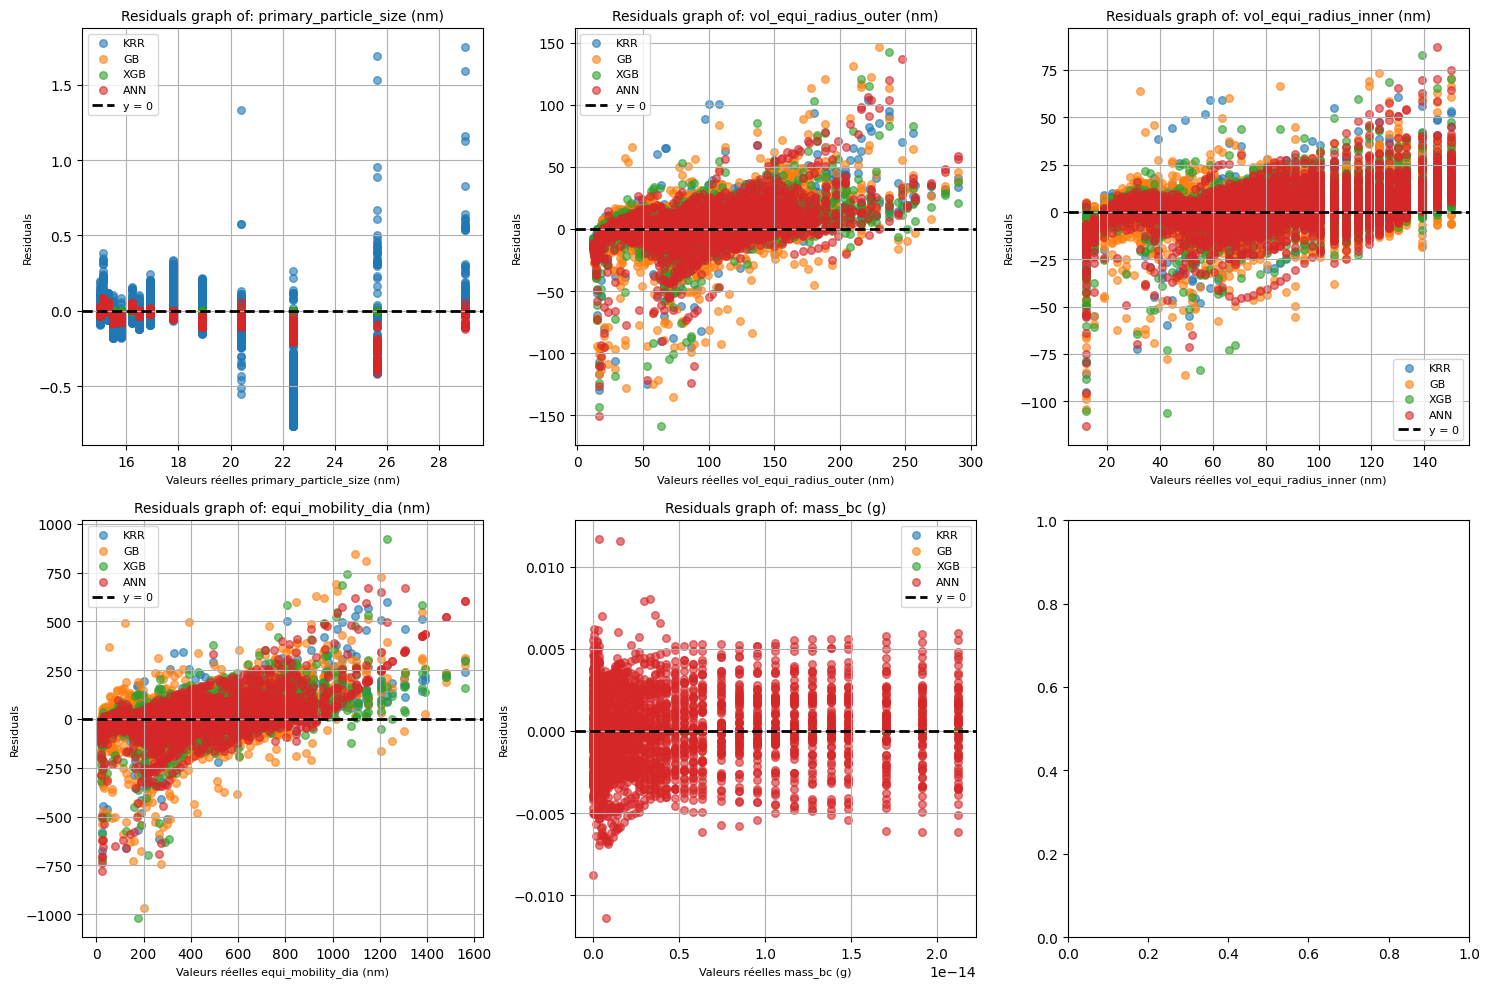

In [30]:
plot_residus(Y_test,predictions_LX,figsize =((15,10)))

#### Tableaux des erreurs

In [31]:
results_mse['KRR'] = df_errors_LX_KRR['MSE']
results_mape['KRR'] = df_errors_LX_KRR['MAPE']
results_r2['KRR'] = df_errors_LX_KRR['R2']

results_mse['GB'] = df_errors_LX_GB['MSE']
results_mape['GB'] = df_errors_LX_GB['MAPE']
results_r2['GB'] = df_errors_LX_GB['R2']

results_mse['XGB'] = df_errors_LX_XGB['MSE']
results_mape['XGB'] = df_errors_LX_XGB['MAPE']
results_r2['XGB'] = df_errors_LX_XGB['R2']

results_mse['ANN'] = df_errors_LX_ANN['MSE']
results_mape['ANN'] = df_errors_LX_ANN['MAPE']
results_r2['ANN'] = df_errors_LX_ANN['R2']

# Créer les DataFrames pour chaque métrique
df_mse = pd.DataFrame(results_mse)
df_mape = pd.DataFrame(results_mape)
df_r2 = pd.DataFrame(results_r2)


# Appliquer le style avec la fonction mise à jour
styled_mse = df_mse.style.apply(highlight_best_by_row, higher_is_better=False, axis=None).set_caption("MSE : Meilleure méthode pour chaque paramètre")
styled_mape = df_mape.style.apply(highlight_best_by_row, higher_is_better=False, axis=None).set_caption("MAPE : Meilleure méthode pour chaque paramètre")
styled_r2 = df_r2.style.apply(highlight_best_by_row, higher_is_better=True, axis=None).set_caption("R² : Meilleure méthode pour chaque paramètre")

# Afficher les tableaux
from IPython.display import display
display(styled_mse)
display(styled_mape)
display(styled_r2)

,KRR,GB,XGB,ANN
equi_mobility_dia (nm),6085.864172,12916.606536,6980.667141,9915.951195
mass_bc (g),0.000000,0.000000,0.000000,0.000005
primary_particle_size (nm),0.034844,0.000000,0.000000,0.005942
vol_equi_radius_inner (nm),100.220970,195.448938,110.349752,150.746999
vol_equi_radius_outer (nm),189.202817,378.677940,198.360312,265.692432


,KRR,GB,XGB,ANN
equi_mobility_dia (nm),0.221204,0.386268,0.243006,0.312841
mass_bc (g),0.395354,5.378694,5.365394,2789921253250.962891
primary_particle_size (nm),0.005821,0.000000,0.000001,0.002787
vol_equi_radius_inner (nm),0.123607,0.185708,0.131623,0.155478
vol_equi_radius_outer (nm),0.123090,0.187892,0.127805,0.151221


,KRR,GB,XGB,ANN
equi_mobility_dia (nm),0.915065,0.819734,0.902577,0.861611
mass_bc (g),0.851345,-0.000001,-0.000008,-193092392189647996846080.000000
primary_particle_size (nm),0.996440,1.000000,1.000000,0.999393
vol_equi_radius_inner (nm),0.925460,0.854634,0.917927,0.887882
vol_equi_radius_outer (nm),0.917005,0.833890,0.912988,0.883452


### L_X avec une combinaison de variables en entrée 

In [69]:
X = df.iloc[:, 2:23]  # données particules
L = df.iloc[:, [0, 1] + list(range(31, df.shape[1]))]

# Sélection des variables intéressantes 
variables = ['primary_particle_size (nm)', 
             'vol_equi_radius_outer (nm)', 
             'vol_equi_radius_inner (nm)', 
             'equi_mobility_dia (nm)',
                "mass_bc (g)"]

X = X[variables]


In [70]:
X_test=L.reset_index(drop=True)
Y_test=X.reset_index(drop=True)

X_test_transformed =  scaler.fit_transform(X_test)   #pt.transform(X_test)
Y_test_transformed = pd.DataFrame(Y_test, columns=Y_test.columns)

#### Avec une seule variable :

Téléchargement des modèles : 

In [71]:
from joblib import load  # Pour charger les modèles enregistrés
import os
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score

# Dossier où les modèles ont été enregistrés
output_dir = '../Best_model/L_X_1_var/'

# Initialisation des DataFrames pour les prédictions
Y_pred_XL_KRR = pd.DataFrame()
Y_pred_XL_GB = pd.DataFrame()

# Liste des modèles à charger (uniquement KRR et GB)
model_names = ['KRR','GB']  # Nous avons gardé seulement les modèles KRR et GB

# Initialisation des dictionnaires pour stocker les erreurs
errors_KRR = {}
errors_GB = {}

# Charger et prédire avec chaque modèle enregistré
for model_name in model_names:
    model_path = os.path.join(output_dir, model_name)
    
    model_files = [f for f in os.listdir(model_path) if f.endswith('.joblib')]
    
    # Initialisation des dictionnaires pour les prédictions
    y_pred = {}
    var = []
    
    for model_file in model_files:
        # Extraire le nom de la variable cible à partir du nom du fichier
        base_name = model_file.replace('.joblib', '')
        
        # Extraire la cible (avant "_best_model") et la variable prédictive (après "_avec_")
        variable_name = base_name.split('_best_model')[0]  # La partie avant "_best_model"
        predictive_variable = base_name.split('_avec_')[-1]  # La partie après "_avec_"
        
        # Extraire le type de modèle (entre "_best_model" et "_avec_")
        model_type = base_name.split('_best_model')[1].split('_avec_')[0] 
        var.append(predictive_variable)
        # Charger le modèle
        model = load(os.path.join(model_path, model_file))

        # Effectuer les prédictions pour chaque variable
        x_input = X_test[[predictive_variable]]
        x_input_transformed =  scaler.fit_transform(x_input) 
        y_pred= model.predict(x_input_transformed)  # Prédictions pour chaque variable
        # Calculer les erreurs
        mse = mean_squared_error(Y_test[[variable_name]], y_pred)
        mape = mean_absolute_percentage_error(Y_test[[variable_name]], y_pred)
        r2 = r2_score(Y_test[[variable_name]], y_pred)
        
        # Stocker les erreurs dans les dictionnaires respectifs
        if model_name == 'KRR':
            errors_KRR[variable_name] = {'MSE': mse, 'MAPE': mape, 'R2': r2}
        elif model_name == 'GB':
            errors_GB[variable_name] = {'MSE': mse, 'MAPE': mape, 'R2': r2}
    
        # Convertir les prédictions en DataFrame
        y_pred_df[variable_name] = y_pred

    # Ajouter les prédictions au DataFrame correspondant au modèle
    if model_name == 'KRR':
        Y_pred_XL_KRR = y_pred_df  # Assigner les prédictions au bon DataFrame
    elif model_name == 'GB':
        Y_pred_XL_GB = y_pred_df

# Convertir les erreurs en DataFrames
df_errors_XL_KRR = pd.DataFrame(errors_KRR).T[['MSE', 'MAPE', 'R2']]
df_errors_XL_GB = pd.DataFrame(errors_GB).T[['MSE', 'MAPE', 'R2']]

In [72]:
new_order = ['equi_mobility_dia (nm)', 'mass_bc (g)', 'primary_particle_size (nm)','vol_equi_radius_inner (nm)','vol_equi_radius_outer (nm)']

# Réorganiser les colonnes
Y_test= Y_test[new_order]

Graphique sauvegardé dans : ../Images_finales\L_X_1_var.png


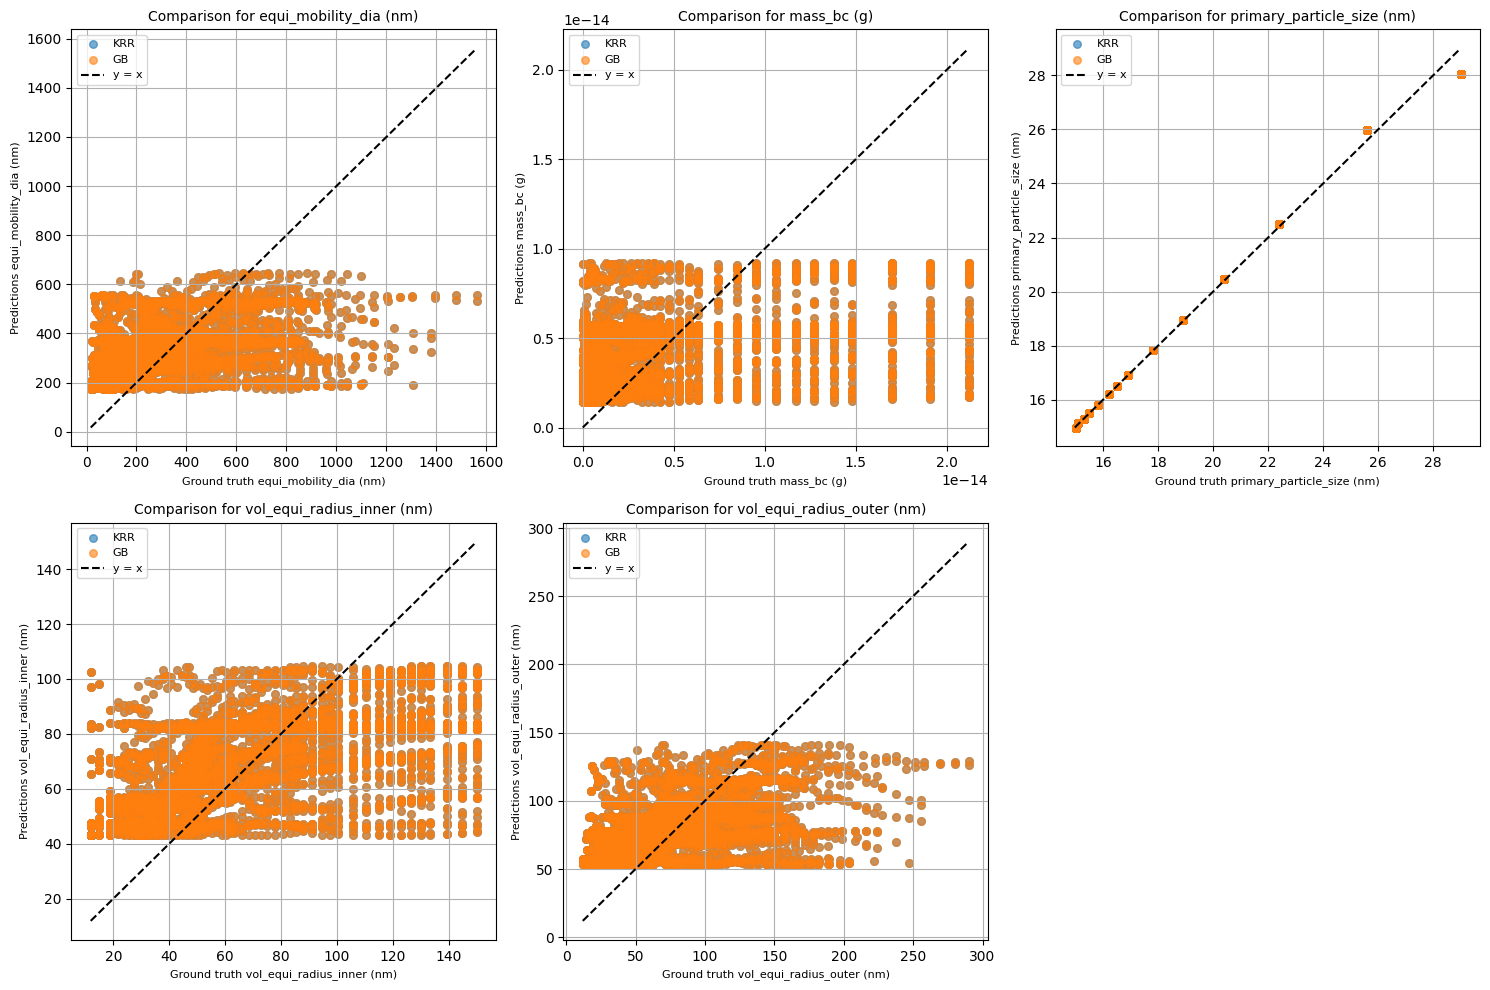

In [73]:
# Fonction pour afficher les graphiques des prédictions vs valeurs réelles
def plot_prediction(Y_test, predictions_dict, figsize,im_name):
    n_cols = 3
    n_rows = (len(Y_test.columns) + n_cols - 1) // n_cols  # Calculer le nombre de lignes nécessaires
    
    # Créer une figure avec n sous-graphiques
    fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=figsize)
    axes = axes.flatten()
    
    # Boucle sur chaque variable cible
    for idx, col in enumerate(Y_test.columns):
        ax = axes[idx]  # Sélectionner le subplot correspondant
        
        # Tracer les valeurs réelles vs prédictions pour chaque modèle
        for model_name, pred_df in predictions_dict.items():
            ax.scatter(Y_test[col], pred_df[col], label=f'{model_name}', alpha=0.6, s=30)

        # Tracer une ligne de référence y = x
        min_val = min(Y_test[col].min(), *(pred_df[col].min() for pred_df in predictions_dict.values() if col in pred_df.columns))
        max_val = max(Y_test[col].max(), *(pred_df[col].max() for pred_df in predictions_dict.values() if col in pred_df.columns))
        x_range = np.linspace(min_val, max_val, 100)
        ax.plot(x_range, x_range, linestyle="--", color="black", label="y = x")

        # Ajouter le titre, les étiquettes, et la légende
        ax.set_title(f'Comparison for {col}', fontsize=10)
        ax.set_xlabel(f'Ground truth {col}', fontsize=8)
        ax.set_ylabel(f'Predictions {col}', fontsize=8)
        ax.legend(fontsize=8)
        ax.grid(True)
    
    # Supprimer les sous-graphiques inutilisés (s'il y a plus de cases que de variables)
    for idx in range(len(Y_test.columns), len(axes)):
        fig.delaxes(axes[idx])
    
    plt.tight_layout()
    # Chemin pour sauvegarder l'image
    output_dir = "../Images_finales"  # Nom du dossier
    if not os.path.exists(output_dir):  # Créer le dossier s'il n'existe pas
        os.makedirs(output_dir)
    
    output_path = os.path.join(output_dir, im_name)  # Chemin complet du fichier
    
    # Sauvegarder le plot
    plt.savefig(output_path, dpi=300, bbox_inches='tight')
    
    print(f"Graphique sauvegardé dans : {output_path}")
    
    plt.show()


# Appeler la fonction pour afficher les graphiques
predictions_dict = {
    'KRR': Y_pred_XL_KRR,
    'GB' : Y_pred_XL_GB
}

# Appeler la fonction pour afficher les graphiques
plot_prediction(Y_test, predictions_dict,figsize=(15, 10),im_name ='L_X_1_var.png')


In [37]:
df_errors_XL_GB

,MSE,MAPE,R2
equi_mobility_dia (nm),5.918011e+04,1.262942,0.174073
mass_bc (g),2.415405e-29,3.909457,0.151303
primary_particle_size (nm),2.738250e-02,0.002689,0.997202
vol_equi_radius_inner (nm),1.041126e+03,0.530069,0.225660
vol_equi_radius_outer (nm),1.808594e+03,0.578509,0.206649


In [38]:
# Créer un DataFrame avec les R² pour chaque modèle et chaque variable
dataR2 = {
    'KRR': {key: value['R2'] for key, value in errors_KRR.items()},
    'GB': {key: value['R2'] for key, value in errors_GB.items()}
}

df_r2 = pd.DataFrame(dataR2)

dataMSE = {
    'KRR': {key: value['MSE'] for key, value in errors_KRR.items()},
    'XGB': {key: value['MSE'] for key, value in errors_GB.items()}
}

df_MSE = pd.DataFrame(dataMSE)

dataMAPE = {
    'KRR': {key: value['MAPE'] for key, value in errors_KRR.items()},
    'XGB': {key: value['MAPE'] for key, value in errors_GB.items()}
}

df_MAPE = pd.DataFrame(dataMAPE)

# Appliquer le style avec la fonction mise à jour
styled_mse = df_MSE.style.apply(highlight_best_by_row, higher_is_better=False, axis=None).set_caption("MSE : Meilleure méthode pour chaque paramètre")
styled_mape = df_MAPE.style.apply(highlight_best_by_row, higher_is_better=False, axis=None).set_caption("MAPE : Meilleure méthode pour chaque paramètre")
styled_r2 = df_r2.style.apply(highlight_best_by_row, higher_is_better=True, axis=None).set_caption("R² : Meilleure méthode pour chaque paramètre")

# Afficher les tableaux
from IPython.display import display
display(styled_mse)
display(styled_mape)
display(styled_r2)

,KRR,XGB
equi_mobility_dia (nm),59180.106171,59180.106171
mass_bc (g),0.000000,0.000000
primary_particle_size (nm),0.027383,0.027383
vol_equi_radius_inner (nm),1041.125932,1041.125932
vol_equi_radius_outer (nm),1808.594151,1808.594151


,KRR,XGB
equi_mobility_dia (nm),1.262942,1.262942
mass_bc (g),3.909457,3.909457
primary_particle_size (nm),0.002689,0.002689
vol_equi_radius_inner (nm),0.530069,0.530069
vol_equi_radius_outer (nm),0.578509,0.578509


,KRR,GB
equi_mobility_dia (nm),0.174073,0.174073
mass_bc (g),0.151303,0.151303
primary_particle_size (nm),0.997202,0.997202
vol_equi_radius_inner (nm),0.225660,0.225660
vol_equi_radius_outer (nm),0.206649,0.206649


### Avec une combinaison de 2 variables :

In [39]:
import os
import json
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score
from joblib import load
import xgboost as xgb

# Chemin vers les fichiers de modèles
model_path = "../Best_model/L_X_2_var"

# Dictionnaire pour stocker les prédictions en fonction des modèles
predictions_LX2 = {
    'KRR': {},
    'GB': {}
}

# Dictionnaires pour stocker les erreurs
errors_KRR2 = {}
errors_XGB2 = {}
errors_ANN2 = {}

# Parcourir les fichiers de modèles
for file in os.listdir(model_path):
    if file.endswith('.joblib'):  # Traitement des modèles KRR/ANN
        base_name = file.replace('.joblib', '')
        
        # Extraire la cible (avant "_best_model") et la variable prédictive (après "_avec_")
        target_variable = base_name.split('_best_model')[0]  # La partie avant "_best_model"
        predictive_variable = base_name.split('_avec_')[-1]  # La partie après "_avec_"
        print(target_variable)
        # Extraire le type de modèle (entre "_best_model" et "_avec_")
        model_type = base_name.split('_best_model')[1].split('_avec_')[0]  # La partie entre "_best_model" et "_avec_"
        
        # Charger le modèle KRR ou ANN
        model = load(os.path.join(model_path, file))
        predictive_variable_name = predictive_variable.strip("()").replace("'", "").split(", ")
        
        # Effectuer les prédictions
        x_input = X_test[[predictive_variable_name[0],predictive_variable_name[1]]].values  # Tableau 2D
        x_input_transformed =  scaler.fit_transform(x_input) 
        y_pred = model.predict(x_input_transformed)
        
        # Stocker les prédictions dans le dictionnaire selon le modèle
        if target_variable not in predictions_LX2[model_type]:
            predictions_LX2[model_type][target_variable] = pd.Series(y_pred, name=target_variable)
        
        # Calculer les erreurs (MSE, MAPE, R2)
        mse = mean_squared_error(Y_test_transformed[target_variable], y_pred)
        mape = mean_absolute_percentage_error(Y_test_transformed[target_variable], y_pred)
        r2 = r2_score(Y_test_transformed[target_variable], y_pred)
        
        # Stocker les erreurs dans le dictionnaire approprié
        if model_type == 'KRR':
            errors_KRR[target_variable] = {'MSE': mse, 'MAPE': mape, 'R2': r2}
        elif model_type == 'ANN':
            errors_ANN[target_variable] = {'MSE': mse, 'MAPE': mape, 'R2': r2}
        elif model_type == 'XGB':
            errors_XGB[target_variable] = {'MSE': mse, 'MAPE': mape, 'R2': r2}

# Créer un DataFrame avec les R² pour chaque modèle et chaque variable
dataR2 = {
    'KRR': {key: value['R2'] for key, value in errors_KRR.items()},
    'GB': {key: value['R2'] for key, value in errors_GB.items()}
}

df_r22 = pd.DataFrame(dataR2)

dataMSE = {
    'KRR': {key: value['MSE'] for key, value in errors_KRR.items()},
    'GB': {key: value['MSE'] for key, value in errors_GB.items()}
}

df_MSE2 = pd.DataFrame(dataMSE)

dataMAPE = {
    'KRR': {key: value['MAPE'] for key, value in errors_KRR.items()},
    'GB': {key: value['MAPE'] for key, value in errors_GB.items()}
}

df_MAPE2 = pd.DataFrame(dataMAPE)


equi_mobility_dia (nm)
equi_mobility_dia (nm)
mass_bc (g)
mass_bc (g)
primary_particle_size (nm)
primary_particle_size (nm)
vol_equi_radius_inner (nm)
vol_equi_radius_inner (nm)
vol_equi_radius_outer (nm)
vol_equi_radius_outer (nm)


Graphique sauvegardé dans : ../Images_finales\L_X_2_var


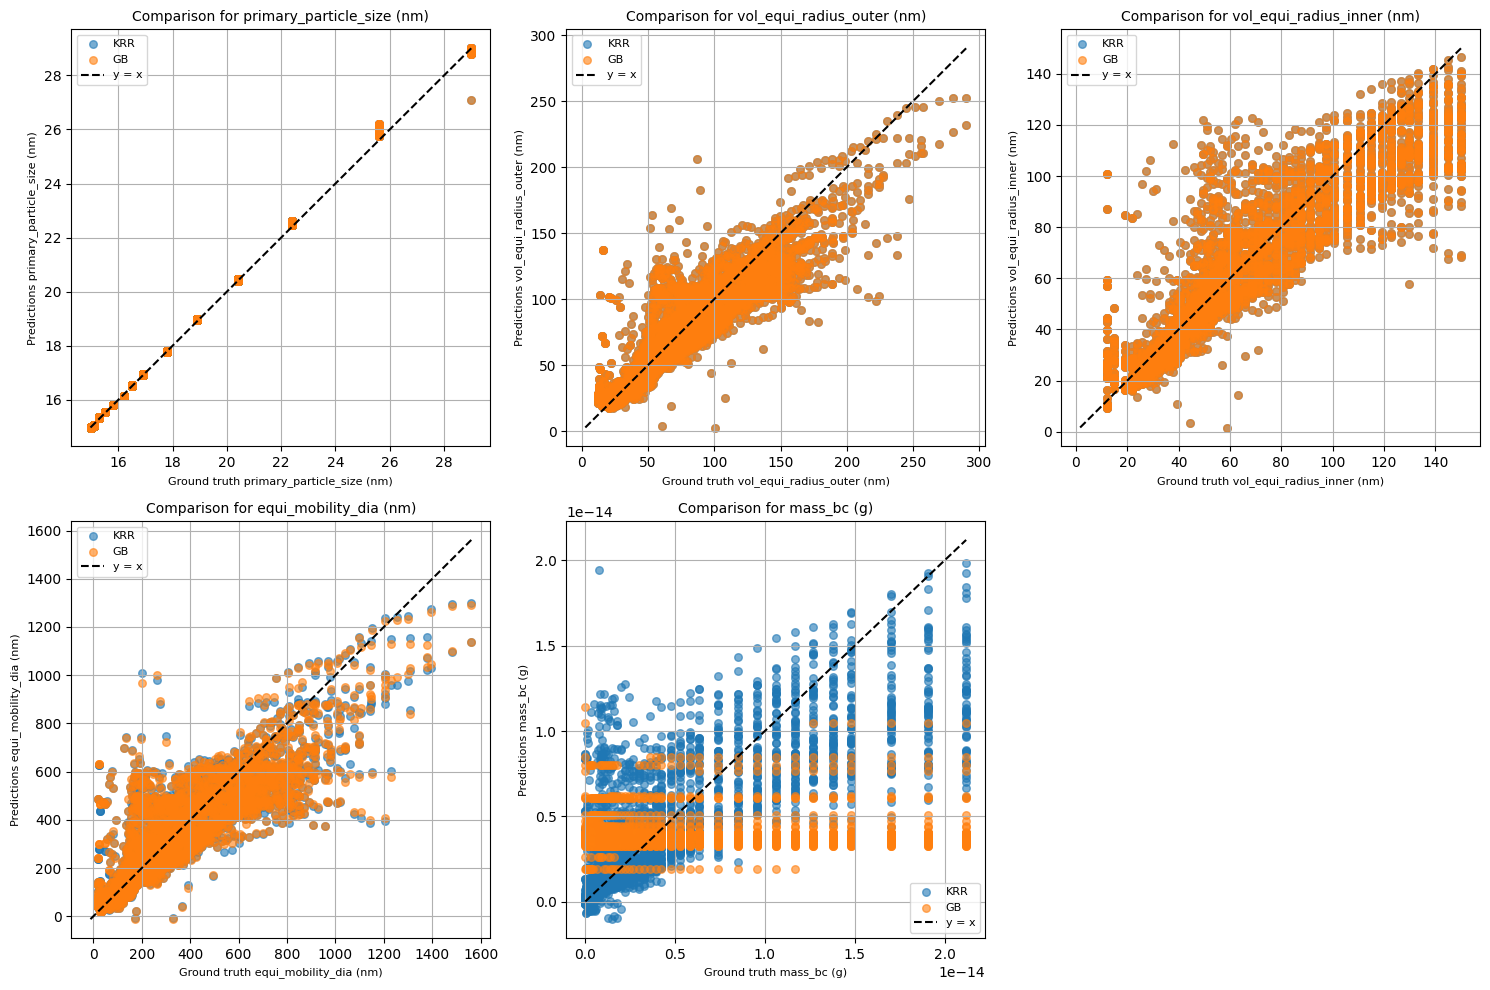

In [75]:
def plot_prediction(Y_test, predictions, figsize,im_name):
    n_cols = 3
    n_rows = (len(Y_test.columns) + n_cols - 1) // n_cols  # Calculer le nombre de lignes nécessaires
    
    # Créer une figure avec n sous-graphiques
    fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=figsize)
    axes = axes.flatten()
    
    # Boucle sur chaque variable cible
    for idx, col in enumerate(Y_test.columns):
        ax = axes[idx]  # Sélectionner le subplot
        
        # Tracer les valeurs réelles vs prédictions pour chaque modèle
        for model_name, pred_df in predictions.items():
            if col in pred_df:  # S'assurer que la colonne est présente dans les prédictions
                # Si pred_df est une série, on n'a pas besoin d'accéder à col
                ax.scatter(Y_test[col], pred_df[col], label=f'{model_name}', alpha=0.6, s=30)

        # Tracer une ligne de référence y = x
        x_range = np.linspace(min(Y_test[col].min(), pred_df[col].min()), max(Y_test[col].max(), pred_df[col].max()), 100)
        ax.plot(x_range, x_range, linestyle="--", color="black", label="y = x")
        
        # Ajouter le titre et les légendes
        ax.set_title(f'Comparison for {col}', fontsize=10)
        ax.set_xlabel(f'Ground truth {col}', fontsize=8)
        ax.set_ylabel(f'Predictions {col}', fontsize=8)
        ax.legend(fontsize=8)
        ax.grid(True)

     # Supprimer les sous-graphiques inutilisés (s'il y a plus de cases que de variables)
    for idx in range(len(Y_test.columns), len(axes)):
        fig.delaxes(axes[idx])
        
    plt.tight_layout()
    output_dir = "../Images_finales"  # Nom du dossier
    if not os.path.exists(output_dir):  # Créer le dossier s'il n'existe pas
        os.makedirs(output_dir)
    
    output_path = os.path.join(output_dir, im_name)  # Chemin complet du fichier
    
    # Sauvegarder le plot
    plt.savefig(output_path, dpi=300, bbox_inches='tight')
    
    print(f"Graphique sauvegardé dans : {output_path}")
    
    plt.show()

# Appeler la fonction pour afficher les graphiques
plot_prediction(Y_test_transformed, predictions_LX2,figsize =(15,10),im_name ='L_X_2_var')


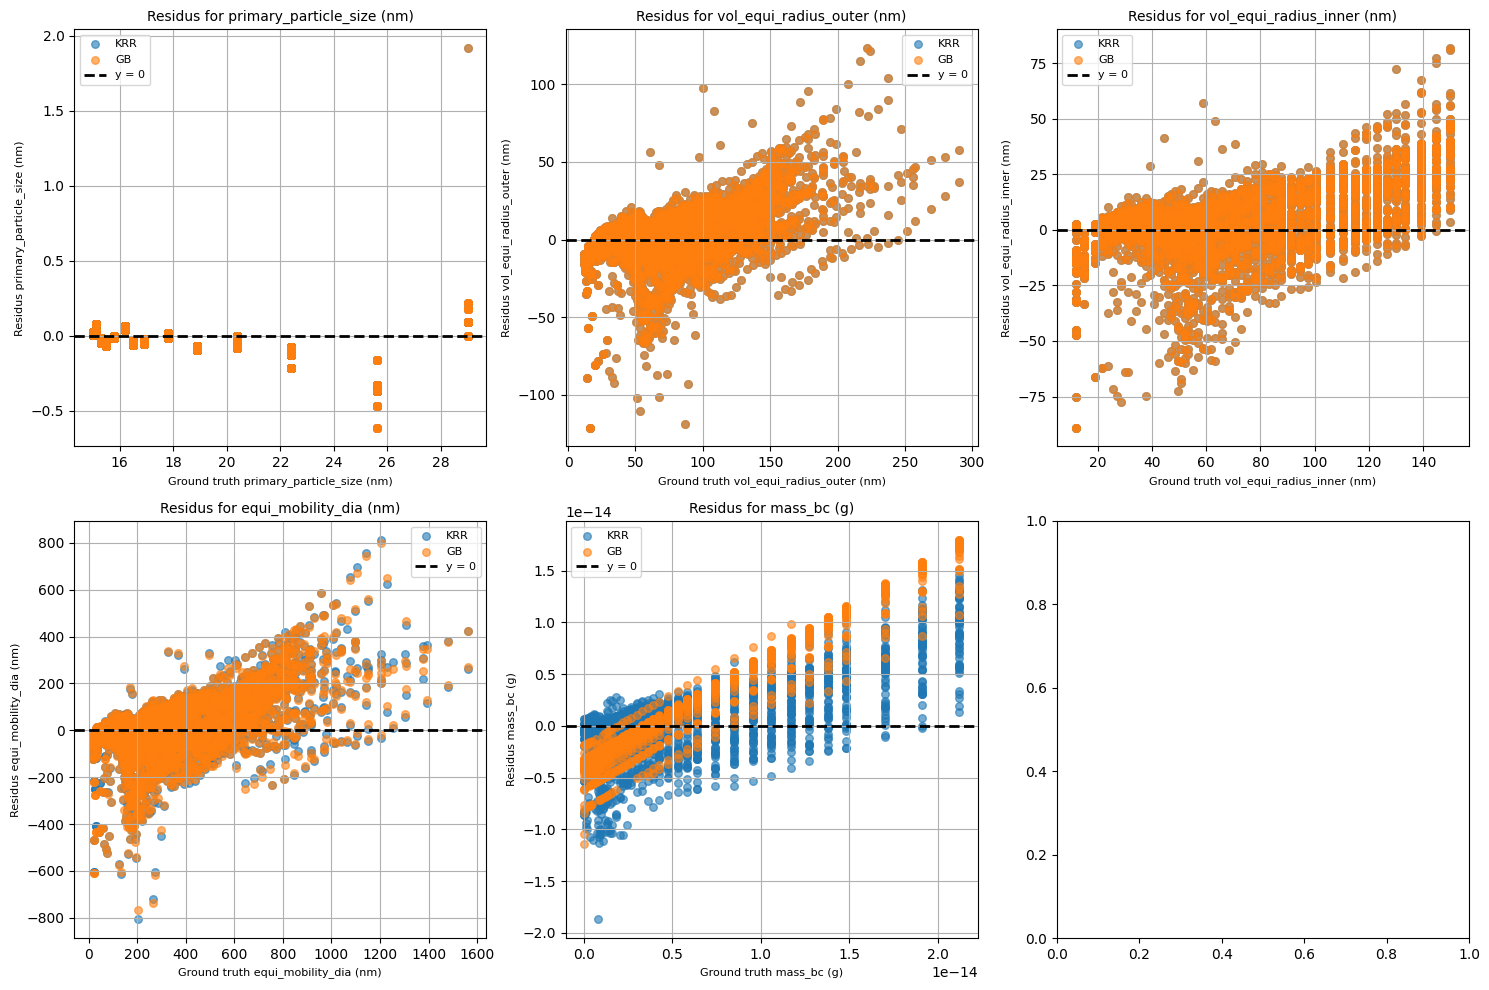

In [41]:
# Fonction pour afficher les graphiques des prédictions vs valeurs réelles
def plot_res(Y_test, predictions, figsize=(15, 10)):
    n_cols = 3
    n_rows = (len(Y_test.columns) + n_cols - 1) // n_cols  # Calculer le nombre de lignes nécessaires
    
    # Créer une figure avec n sous-graphiques
    fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=figsize)
    axes = axes.flatten()
    
    # Boucle sur chaque variable cible
    for idx, col in enumerate(Y_test.columns):
        ax = axes[idx]  # Sélectionner le subplot
        
        # Tracer les valeurs réelles vs prédictions pour chaque modèle
        for model_name, pred_df in predictions.items():
            if col in pred_df:  # S'assurer que la colonne est présente dans les prédictions
                res = Y_test[col].values - pred_df[col].values
                ax.scatter(Y_test[col].values, res, label=f'{model_name}', alpha=0.6, s=30)

        # Ajouter une ligne horizontale y = 0 pour référence
        ax.axhline(0, color='black', linestyle='--', linewidth=2, label='y = 0')
    
        # Ajouter le titre et les légendes
        ax.set_title(f'Residus for {col}', fontsize=10)
        ax.set_xlabel(f'Ground truth {col}', fontsize=8)
        ax.set_ylabel(f'Residus {col}', fontsize=8)
        ax.legend(fontsize=8)
        ax.grid(True)
    
    plt.tight_layout()
    plt.show()

# Appeler la fonction pour afficher les graphiques
plot_res(Y_test_transformed, predictions_LX2)


In [42]:
# Appliquer le style avec la fonction mise à jour
styled_mse = df_MSE2.style.apply(highlight_best_by_row, higher_is_better=False, axis=None).set_caption("MSE : Meilleure méthode pour chaque paramètre")
styled_mape = df_MAPE2.style.apply(highlight_best_by_row, higher_is_better=False, axis=None).set_caption("MAPE : Meilleure méthode pour chaque paramètre")
styled_r2 = df_r22.style.apply(highlight_best_by_row, higher_is_better=True, axis=None).set_caption("R² : Meilleure méthode pour chaque paramètre")

# Afficher les tableaux
from IPython.display import display
display(styled_mse)
display(styled_mape)
display(styled_r2)

,KRR,GB
equi_mobility_dia (nm),17940.342880,59180.106171
mass_bc (g),0.000000,0.000000
primary_particle_size (nm),0.009093,0.027383
vol_equi_radius_inner (nm),317.479673,1041.125932
vol_equi_radius_outer (nm),479.932275,1808.594151


,KRR,GB
equi_mobility_dia (nm),0.419217,1.262942
mass_bc (g),1.019671,3.909457
primary_particle_size (nm),0.002906,0.002689
vol_equi_radius_inner (nm),0.220720,0.530069
vol_equi_radius_outer (nm),0.220914,0.578509


,KRR,GB
equi_mobility_dia (nm),0.749622,0.174073
mass_bc (g),0.645515,0.151303
primary_particle_size (nm),0.999071,0.997202
vol_equi_radius_inner (nm),0.763874,0.225660
vol_equi_radius_outer (nm),0.789475,0.206649
